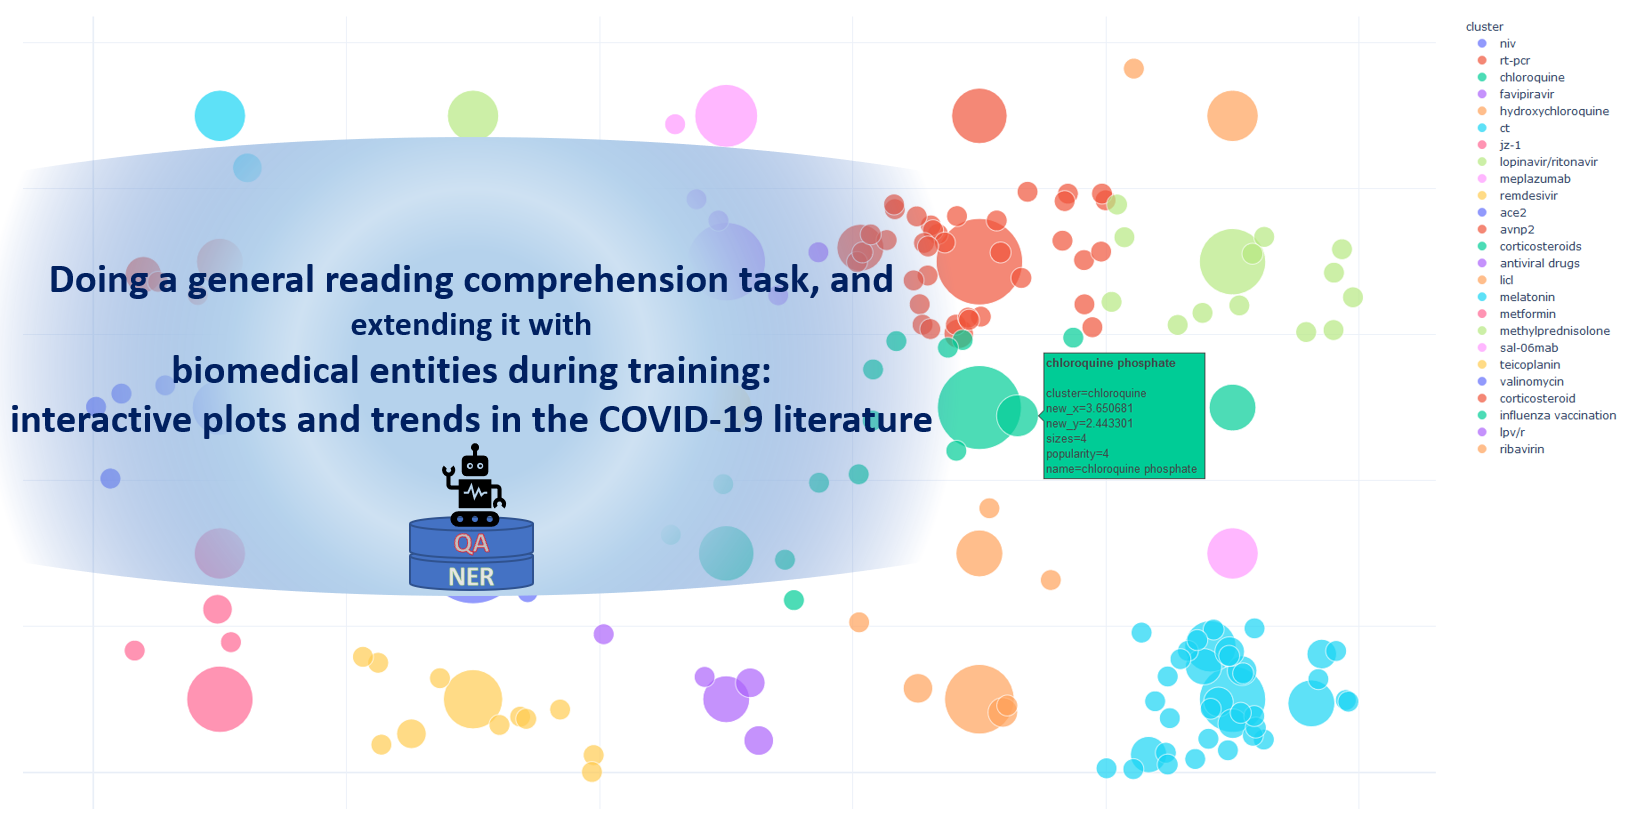





# **Intro:** 

Population, Intervention, Comparator, and Outcomes (PICO) are key parts of medical systematic or rapid reviews of literature. Since 2005, a significant amount of research already focused on mining this type of information. Using some pre-Covid-19 training data and fine-tuned neural networks, I will show how my system can be used now in order to support evidence synthesis. 

## **My previous work as basis for this notebook:** 

1. Integrated existing corpora of annotated biomedical entities (5000 abstracts annotated with data of interest to many CORD-19 challenges*)

2. Transformed the baseline task of extracting entities into a Question-Answering task in order to utilise further general reading comprehension data from the SQuAD corpus (I did/evaluated/published these models early February).

3. Described a process of enriching NER data through the Squad corpus, and to describe how this boosts the results


## **Contribution to CORD-19:**

1. Applying the aforementioned models to abstracts in the CORD dataset
2. Processing the results, deriving interactive plots, trends between different versions of the dataset, word clouds...
3. Trying to provide a framework that allows to integrate all available training data over time!


### TL;DR :  Merge existing NER (biomedical) and reading comprehension (general topic) data. Get a high-performing specialised population, health condition, and outcome classifier with general reading-comprehension ability. Also, aim is to present data interactively and in a meaningful way.



*I did not even train models on most tasks! But it is possible with the code in this notebook/my GIT! The corpus has age-group, samle size, pharma vs non-pharma, and outcome types such as mortality or different adverse events annotated https://ebm-nlp.herokuapp.com/annotations 

About merging it with SquAD: I  did not even use the whole SQuAD data because its just **too much training data ** and my GPU access is limited


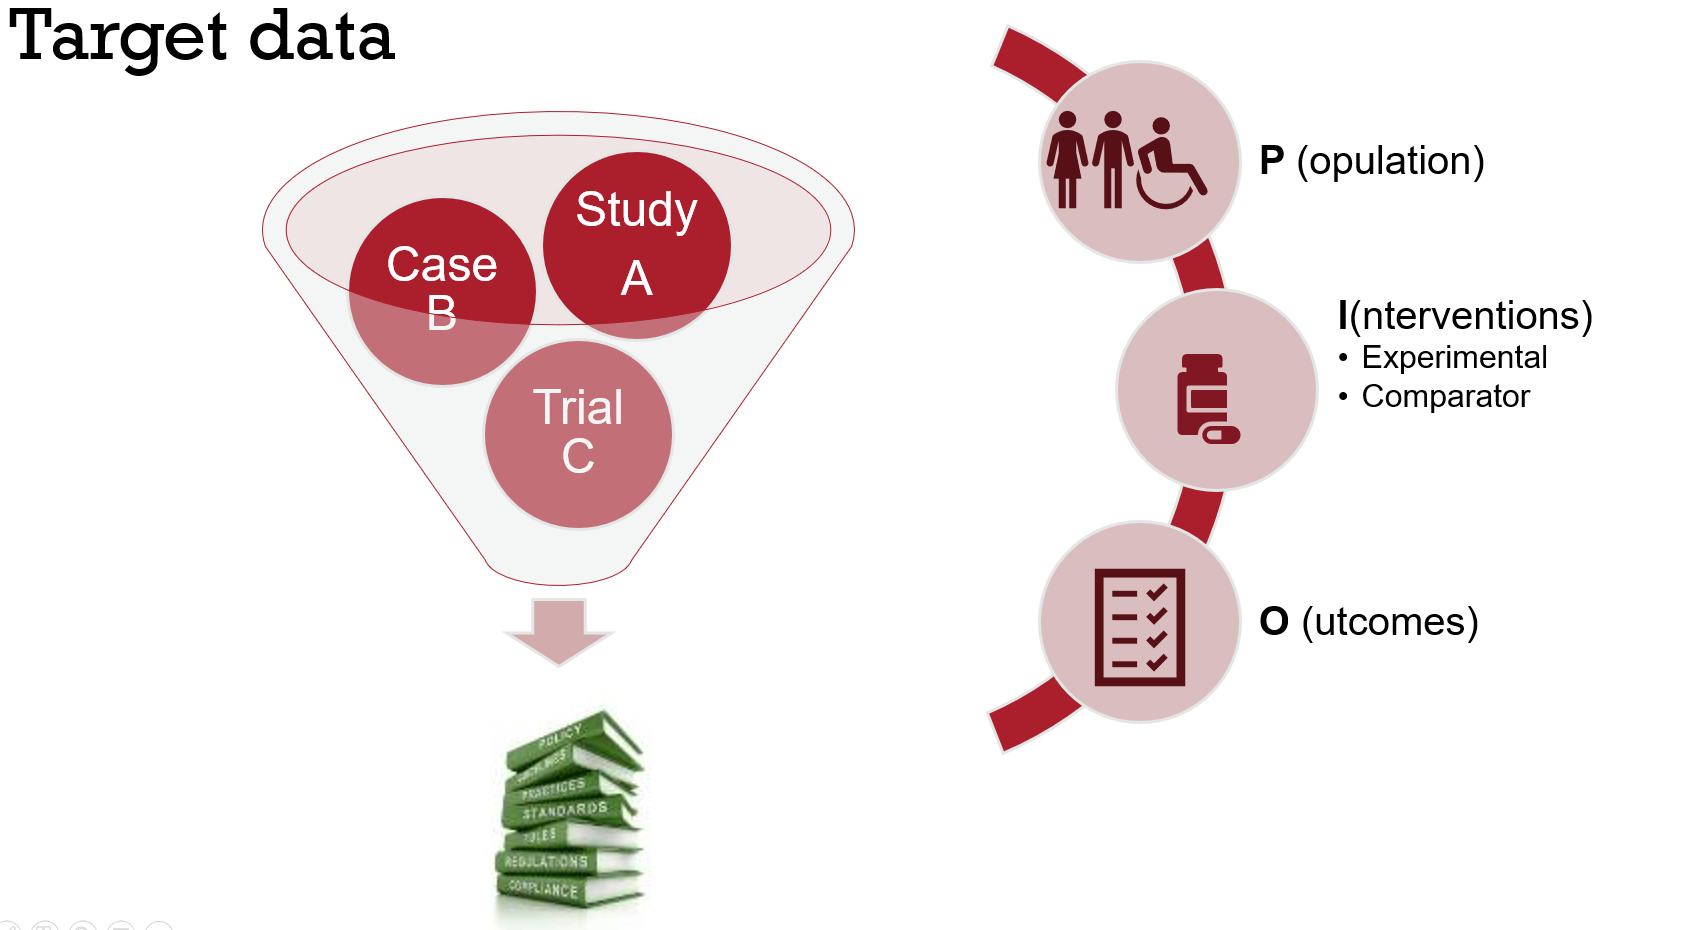
# Teaser - Results
## Example for an interactive plot on diseases and symptoms connected with COVID-19

> **Question for each epidemiological study: 'Patients with which medical conditions were included?**

This is a small teaser, showing mined medical conditions and probable corona-related diseases in the dataset. The plot is interactive, and on hover shows some more detailled information about the mined health problem, as well as the cluster it was assigned to! More detailed explanation of the code will be added in each single task submission.



In [ ]:
#Clone and install sources from GIT
!pip install git+https://github.com/L-ENA/transformers
!git clone https://github.com/L-ENA/CORD19scripts    

###general imports
import os
import re
import pandas as pd
import json
import numpy as np
import collections
from collections import Counter
from collections import defaultdict
from glob import glob
from tqdm import tqdm
import random

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from IPython.display import display, HTML
pd.set_option('display.max_rows', 5)


##set up kaggle working dirs
os.makedirs('/kaggle/working/predictions/')
os.makedirs('/kaggle/working/predictions/plots/')
os.makedirs('/kaggle/working/train_test_pred_data/')

In [ ]:
#import my scripts and functions and process data for the interventions
from CORD19scripts import covid_input

#The methods for obtaining these predicions are described in this Notebook's Methods section on a high level, and they will be decribed in-depth for every separate task submission
#do something with the predictions: first we need to post-processs them a tiny bit, then link the to the original dataset and sort them by frequency
print("Processing Condition predictions......")
covid_input.connectInput(["/kaggle/working/CORD19scripts/predictions/outputs"], mode="Condition")   #modes "Condition" or else "Population"for Patints or else "Intervention"  #to make unified csv file

df = pd.read_csv("/kaggle/working/predictions/predictionsLENA_C.csv")#show the data
display(df[:5])

Above we can see that the raw results from the data mining are not a bad starting point. When sorted by frequency count pneumonia comes up as the top health condition, which is sadly also true in the real world. But there are a lot of duplicates here.....

Below I am doing some post-processing and clustering on the data. This will be explained in more detail in my task-specific submissions. The resulting top 5 health conditions show for example that cancer and lung cancer have been grouped! 

All in all, this step reduces 566 unique descriptions of health conditions to 291 clusters, and in the resulting data frame we see that for example "pneumonia (ncp)" and "severe covid-19 pneumonia" get grouped, and that "type 2 diabetes" is now part of the "diabetes" cluster.

In [ ]:
#The we run a simple unsupervised clustering based on substrings in the mined data
print("Deduplicating and clustering Intervention predictions......")
covid_input.deduplicate_predictions("predictions/predictionsLENA_C.csv", mode="C")

df = pd.read_csv("/kaggle/working/predictions/C_deduped.csv")
display(df[:5])

In [ ]:
from CORD19scripts import interactive_plots
    
#Params:
#
#"n_entries = 5" means that we will display 5*5=25 top mining results in the interactive plot
#"mode="C" means that we will look at C(ondition)-type entities

interactive_plots.make_plot_kaggle(n_entries = 5, mode="C") 

## Example 2 for an interactive plot on medical care: 

> **Question for each epidemiological study: 'What was the intervention given to the participants?'**

This is another small teaser, showing my mined medical interventions in the dataset. The plot is interactive, and on hover shows some more detailled information about the mined procedure, as well as the cluster it was assigned to! More detailed explanation of the code will be added in each task submission.



In [ ]:
#do something with the predictions: first we need to post-processs them a tiny bit, then link the to the original dataset and sort them by frequency
print("Processing Intervention predictions......")
covid_input.connectInput(["/kaggle/working/CORD19scripts/predictions/outputs"], mode="Intervention")   #modes "Condition" or else "Population"for Patints or else "Intervention"  #to make unified csv file

#The we run a simple unsupervised clustering based on substrings in the mined data
print("Deduplicating and clustering Intervention predictions......")
covid_input.deduplicate_predictions("predictions/predictionsLENA_I.csv", mode="I")

In [ ]:
#Params:
#
#"n_entries = 5" means that we will display 5*5=25 top mining results in the interactive plot - feel free to change this and to zoom in and out of the plots
#"mode="I" means that we will look at I(ntervention)-type entities

interactive_plots.make_plot_kaggle(n_entries = 5, mode="I") 

# Methods

# The training data:

1) 5000 entity-annotated abstracts of medical clinical trials [1].* 

2) The SQuAD v.2 data for general reading comprehension in question answering, we will use random parts of the corpus, at most 200 domains [2].

3) Jumping on the Transformer train; we can use basically any pre-trained architecture capable of performing the SQuAD task implemented by Huggingface's Transformers [3]. NB I will use my own fork of this repo but I still download the pretrained models from them.

[1] https://ebm-nlp.herokuapp.com/annotations 

[2] https://rajpurkar.github.io/SQuAD-explorer/

[3] https://huggingface.co/

*, ultimately it'd be great to use any other NER dataset in the following architecture


# Aim:
We will harness BERTs (or XL-Net or ANY transformers) power of **domain adaptation and transfer learning** to extract entities from any epidemiological study on COVID. 


Following is a short overview and some code on how to merge the datasets and what the final architecture looks like on a super-high level.

# Creating the training, testing, and prediction data

### Step 1: Familiarise myself with the SQuAD data format (json file), and adapt the corpus

* SQuAD consists of domains - namely a whole Wikipedia article as one domain - PURPLE in the picture below
* Each domain has some question contexts (something like a paragraph of text) - YELLOW 
* Questions about the text, potentially multiple questions about the same paragraph - BLUE
* Span-annotations of where the labelled answer is OR if there is no answer, a boolean to indicate that - GREEN

When I adapt the ebm-nlp corpus: 
* abstracts become domains (purple) 
* sentences become question contexts (yellow)
* entity types become questions (I created a list of questions that aim to comprehensively ask for entity types, examples below*)
* sentences with labelled entities become proper span-answers, and sentences without entity become "impossible answers" - NB depending on entity type it is worth considering under-sampling some of the impossible answers in order to boost recall (I am a systematic reviewer-turned data scientist so I really care about recall most (ie retrieving ALL entities), and F1 second. This is how systematic reviewing works, and what medical researchers are going to expect if they ever use a tool like this one...)
* N amount of Original SQuAD domains (eg 200) are randomly selected, and shuffeled in between my adapted ebm-nlp training data. NB of course I don't use any additional SQuAD domains in the evaluation data, because I want my results to be comparable with other architectures trained on the basis of the same data. And even more obvious: I use the ebm-nlp expert-annotated held-out abstracts for evaluation.


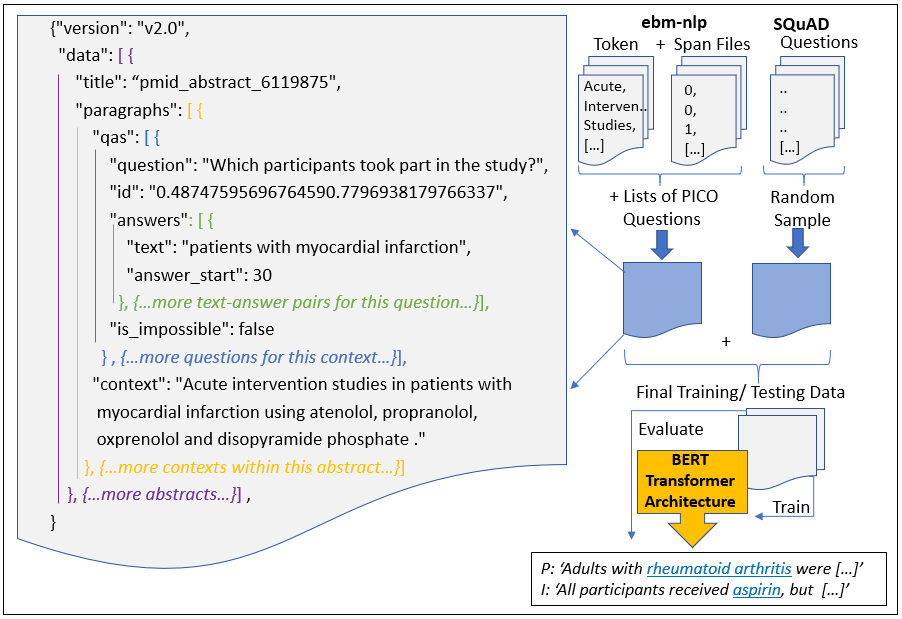


*, eg asking for study population, I compiled these options: 

quests = ['Who was treated?', 'What were the criteria for enrollment?', 'What were the inclusion criteria?',
                      'Who was enrolled in the study?', 'What were participants diagnosed with?',
                      'Which participants took part in the study?']

In [ ]:
from CORD19scripts import make_train_test


ebmnlp_path="/kaggle/input/ebmnlp/ebm_nlp_2_00/ebm_nlp_2_00"#path to annotated data
squad_path="/kaggle/input/squad-20"#path to squad data

#Create the training and evaluation data that will be used to fine-tune the Transformer model!
make_train_test.make_data(ebmnlp_path,squad_path, entity="I", makeTest=True, add_dev=0)#make the testing data
make_train_test.make_data(ebmnlp_path,squad_path, entity="I", makeTest=False, undersample_frac = 0.3, add_dev=0,add_train=170)#make and save the file in this notebooks output directory, can be downloaded on the right sidebar under "/kaggle/working/train_test_pred_data"





# Fine-tune a Question-answering model on the newly created training data

Then, I use the Transformers library mentioned above and to fine-tune my own Frankenstein-NER-QA models
With a bit of work on my own fork of Transformers I can display evaluation results as needed - e.g. per-class recall scores in order to adjust undersampling rate of my training data

For fine-tuning itself I use Googe Colab, whith the GPU option enabled. When doing this, one simply needs to upload their training and evaluation files (created in the previous step), save them in a google drive and point the script to the right folder. After fine-tuning all tuned weights will be saved in the outputs folder. 

The Colab script can be found here: https://github.com/L-ENA/CORD19scripts/blob/master/CORD_mining.ipynb

As this is a bit resource intensive, all fine-tuned weights are aviailable here: TODO upload to kaggle


# Convert the CORD-19 data into a format that we can feed to the network


In [ ]:
from CORD19scripts import covid_input

#just slightly adjusting the cord dataframe to fit my previous scripts. 
#Also, we are selecting only publications after 2020 when using the "min_date=2020" parameter
covid_input.rewrite_cord_data("/kaggle/input/CORD-19-research-challenge/metadata.csv", max_rows=150000, min_date=2020)

#saves 'sent_map.csv'to the kaggle output predictions folder, and the data to predict to "train_test_pred_data" folder
#if we give types="I" as parameter, like below,  then it will make a file called "dev-v2.0_cord_pred_I.json", indicating that this is:
#a "dev" file for the v2 SQuAD task
#that it is based on the "cord" data
#and that it is for entity type "I"; 

#NB when feeding this file to the network its easiest to just rename it like the original squad dev file: "dev-v2.0.json"
covid_input.makeInput(["/kaggle/working/covid_data.csv"], types="I")

# Predict on CORD data

This is essentially a repetition ofthe fine-tuning step, just that one now removes the do train parameter in the colab file and selects a previous trained model as input to compute the predictions!

There are cells in the COLAB file that do and explain this, and I hope to acutally include the colab script in this Kaggle notebook once I figure out how to do this!

Each CORD task will have its own notebook, where I will go more into detail, and show more data and more visualisations!